# Results summary

| Logistic Regression                                                     | LightGBM Classifier                                                    | Logistic Regression + ATgfe                                        |
|-------------------------------------------------------------------------|------------------------------------------------------------------------|--------------------------------------------------------------------|
| <ul>     <li>10-CV Accuracy: 0.926</li><li>Test-data Accuracy: 0.911</li><li>ROC_AUC: 0.99</li> </ul>        |  <ul>     <li>10-CV Accuracy: 0.946</li><li>Test-data Accuracy: 0.977</li><li>ROC_AUC: 1.0</li> </ul>    | <ul>  <li>10-CV Accuracy: **0.98**</li><li>Test-data Accuracy: **1.0**</li><li>ROC_AUC: **1.0**</li> </ul> |

# Import packages

In [1]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score, recall_score
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
from lightgbm import LGBMClassifier
from sklearn import datasets

In [2]:
def prepare_column_names(columns):
    return [col.replace(' ', '').replace('(cm)', '_cm') for col in columns]

In [3]:
sklearn_data = datasets.load_iris()
columns = prepare_column_names(sklearn_data.feature_names)
df = pd.DataFrame(data=sklearn_data.data, columns=columns)
df['class'] = sklearn_data.target
df['class'] = df['class'].astype(str)
df.head()

,sepallength_cm,sepalwidth_cm,petallength_cm,petalwidth_cm,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
target = 'class'
X = df.drop(target, axis=1).copy()
Y = df.loc[:, target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [5]:
classes = ['setosa', 'versicolor', 'virginica']
numerical_features = X.columns.tolist()

In [6]:
def classification_report(model):
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()                 

In [7]:
def roc_auc(model):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [8]:
def confusion_matrix(model):
    visualizer = ConfusionMatrix(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [9]:
def precision_recall_curve(model):
    visualizer = PrecisionRecallCurve(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [10]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [11]:
def score_test_data_for_model(model, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Balanced Accuracy: {}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

In [12]:
def create_new_model():
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state=77, n_jobs=-1, solver='saga'))
    return model

# Using LightGBM

In [13]:
lgbm_model = LGBMClassifier(n_estimators=100, random_state=7)

In [14]:
score_model(lgbm_model, X, Y)

Mean of metric: 0.9466666666666665, std: 0.040000000000000015


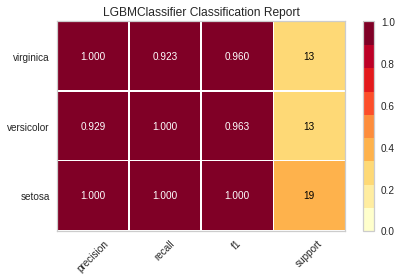

In [15]:
classification_report(lgbm_model)

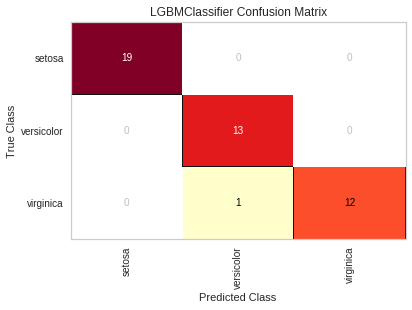

In [16]:
confusion_matrix(lgbm_model)

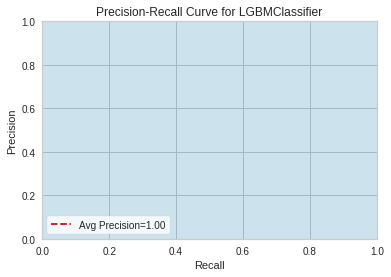

In [17]:
precision_recall_curve(lgbm_model)

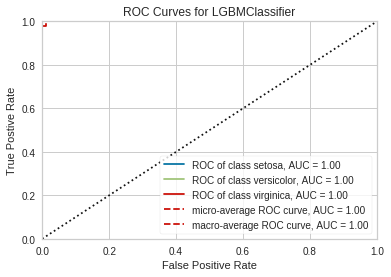

In [18]:
roc_auc(lgbm_model)

In [19]:
lgbm_model.fit(X_train, y_train)
score_test_data_for_model(lgbm_model, X_test, y_test)

Balanced Accuracy: 0.9743589743589745
Accuracy: 0.9777777777777777


# Using Logistic Regression

In [20]:
model = create_new_model()

In [21]:
score_model(model, X, Y)

Mean of metric: 0.9266666666666665, std: 0.06289320754704404


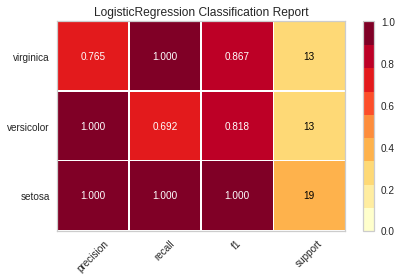

In [22]:
classification_report(model)

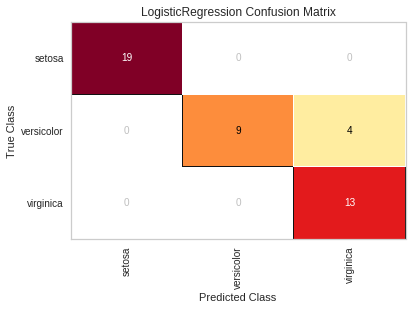

In [23]:
confusion_matrix(model)

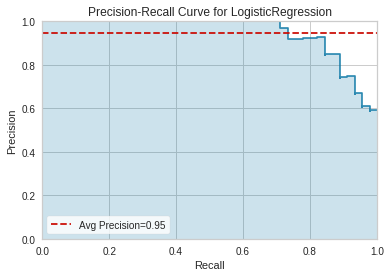

In [24]:
precision_recall_curve(model)

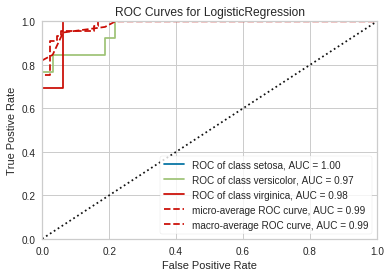

In [25]:
roc_auc(model)

In [26]:
score_test_data_for_model(model, X_test, y_test)

Balanced Accuracy: 0.8974358974358975
Accuracy: 0.9111111111111111


# Using ATgfe

In [27]:
model = create_new_model()

In [28]:
def micro_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, average='micro')

In [29]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=2, number_of_interacting_features=4,
                             evaluation_metric=micro_recall_score, minimize_metric=False, enable_weights=True,
                             n_jobs=62, cross_validation_in_objective_func=True, objective_func_cv=3)

2019-11-27 14:11:36,342:INFO: New Engineer created with the following parameters: 
2019-11-27 14:11:36,343:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['sepallength_cm', 'sepalwidth_cm', 'petallength_cm', 'petalwidth_cm']
Number of candidate features: 2
Number of interacting features: 4
Evaluation Metric: micro_recall_score
Minimize metric is False 


In [30]:
gfe.fit(mu=10, lambda_=120, early_stopping_patience=5, mutation_probability=0.4, crossover_probability=0.6)

Start of evolution
   	      	                                                fitness                                                
   	      	-------------------------------------------------------------------------------------------------------
gen	nevals	avg   	best_val_score	gen	gen_val_score	max     	min   	nevals	std  	time_in_seconds
0  	10    	-1e+10	nan           	0  	nan          	0.941971	-1e+11	10    	3e+10	nan            
1  	120   	0.94017	0.933081      	1  	0.933081     	0.941971	0.932167	120   	0.0036211	2.49478        
2  	120   	0.942952	0.933081      	2  	0.933081     	0.951775	0.941971	120   	0.00294118	2.61988        
3  	120   	0.948914	0.953283      	3  	0.953283     	0.951775	0.941971	120   	0.00437611	2.57015        
4  	120   	0.951775	0.953283      	4  	0.953283     	0.951775	0.951775	120   	0         	2.60284        
5  	120   	0.951775	0.953283      	5  	0.953283     	0.951775	0.951775	120   	0         	2.55816        
6  	120   	0.951775	0.953283      	6

# Apply GFE

In [31]:
new_X = gfe.transform(X)

In [32]:
new_X.head(20)

,sepallength_cm,sepalwidth_cm,petallength_cm,petalwidth_cm,0.543859649122807*squared(petallength_cm)/cube(sepalwidth_cm),0.147891891891892*squared(petallength_cm)*squared(petalwidth_cm)*log(sepallength_cm)/sepallength_cm
0,5.1,3.5,1.4,0.2,0.024862,0.003704
1,4.9,3.0,1.4,0.2,0.039480,0.003761
2,4.7,3.2,1.3,0.2,0.028049,0.003292
3,4.6,3.1,1.5,0.2,0.041076,0.004416
4,5.0,3.6,1.4,0.2,0.022847,0.003732
5,5.4,3.9,1.7,0.4,0.026497,0.021356
6,4.6,3.4,1.4,0.3,0.027121,0.008655
7,5.0,3.4,1.5,0.2,0.031134,0.004284
8,4.4,2.9,1.4,0.2,0.043707,0.003904
9,4.9,3.1,1.5,0.1,0.041076,0.001079


In [33]:
model = create_new_model()

In [34]:
score_model(model, new_X, Y)

Mean of metric: 0.9800000000000001, std: 0.04268749491621899


In [35]:
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.3, random_state=42)

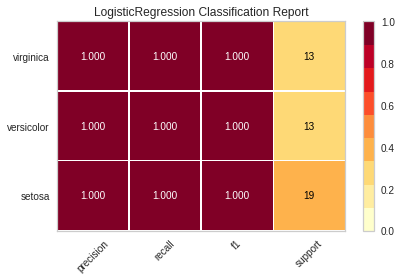

In [36]:
classification_report(model)

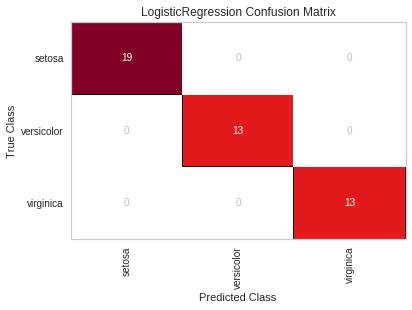

In [37]:
confusion_matrix(model)

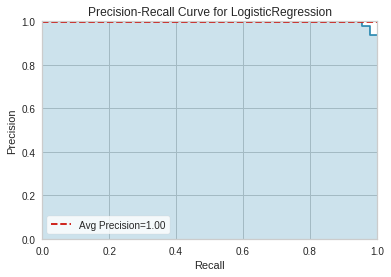

In [38]:
precision_recall_curve(model)

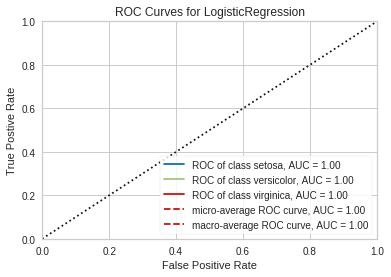

In [39]:
roc_auc(model)

In [40]:
score_test_data_for_model(model, X_test, y_test)

Balanced Accuracy: 1.0
Accuracy: 1.0
